In [103]:
import pandas as pd

from matplotlib import pyplot as plt
from pymgrid import Microgrid
from pymgrid.envs import DiscreteMicrogridEnv
from pymgrid.algos import RuleBasedControl
import gym

In [104]:
import numpy as np
import yaml

from pymgrid.microgrid import DEFAULT_HORIZON
from pymgrid.modules.base import BaseTimeSeriesMicrogridModule


class RenewableModuleCustom(BaseTimeSeriesMicrogridModule):
    """
    A renewable energy module.

    The classic examples of renewables are photovoltaics (PV) and wind turbines.

    Parameters
    ----------
    time_series : array-like, shape (n_steps, )
        Time series of renewable production.

    forecaster : callable, float, "oracle", or None, default None.
        Function that gives a forecast n-steps ahead.

        * If ``callable``, must take as arguments ``(val_c: float, val_{c+n}: float, n: int)``, where

          * ``val_c`` is the current value in the time series: ``self.time_series[self.current_step]``

          * ``val_{c+n}`` is the value in the time series n steps in the future

          * n is the number of steps in the future at which we are forecasting.

          The output ``forecast = forecaster(val_c, val_{c+n}, n)`` must have the same sign
          as the inputs ``val_c`` and ``val_{c+n}``.

        * If ``float``, serves as a standard deviation for a mean-zero gaussian noise function
          that is added to the true value.

        * If ``"oracle"``, gives a perfect forecast.

        * If ``None``, no forecast.

    forecast_horizon : int.
        Number of steps in the future to forecast. If forecaster is None, ignored and 0 is returned.

    forecaster_increase_uncertainty : bool, default False
        Whether to increase uncertainty for farther-out dates if using a GaussianNoiseForecaster. Ignored otherwise.

    provided_energy_name: str, default "renewable_used"
        Name of the energy provided by this module, to be used in logging.

    raise_errors : bool, default False
        Whether to raise errors if bounds are exceeded in an action.
        If False, actions are clipped to the limit possible.

    """
    module_type = ('renewable', 'flex')
    yaml_tag = u"!RenewableModule"
    yaml_loader = yaml.SafeLoader
    yaml_dumper = yaml.SafeDumper

    state_components = np.array(["renewable"], dtype=object)

    def __init__(self,
                 time_series,
                 raise_errors=False,
                 forecaster=None,
                 forecast_horizon=DEFAULT_HORIZON,
                 forecaster_increase_uncertainty=False,
                 forecaster_relative_noise=False,
                 initial_step=0,
                 final_step=-1,
                 normalized_action_bounds=(0, 1),
                 provided_energy_name='renewable_used',
                 operating_cost=0.0):
        super().__init__(
            time_series,
            raise_errors,
            forecaster=forecaster,
            forecast_horizon=forecast_horizon,
            forecaster_increase_uncertainty=forecaster_increase_uncertainty,
            #forecaster_relative_noise=forecaster_relative_noise,
            initial_step=initial_step,
            final_step=final_step,
            normalized_action_bounds=normalized_action_bounds,
            provided_energy_name=provided_energy_name,
            absorbed_energy_name=None
        )
        self.operating_cost = operating_cost

    def update(self, external_energy_change, as_source=False, as_sink=False):
        assert as_source, f'Class {self.__class__.__name__} can only be used as a source.'
        assert external_energy_change <= self.current_renewable, f'Cannot provide more than {self.current_renewable}'

        info = {'provided_energy': external_energy_change,
                'curtailment': self.current_renewable-external_energy_change}

        reward = -1.0 * self.operating_cost * external_energy_change

        return reward, self._done(), info

    @property
    def max_production(self):
        return self.current_renewable

    @property
    def current_renewable(self):
        """
        Current renewable production.

        Returns
        -------
        renewable : float
            Renewable production.

        """
        return self._time_series[self._current_step].item()

    @property
    def is_source(self):
        return True

    @property
    def production_marginal_cost(self):
        return self.operating_cost

In [105]:
from pymgrid.modules import (
    BatteryModule,
    LoadModule,
    RenewableModule,
    GridModule,
    GensetModule)

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

battery = BatteryModule(
    min_capacity=15,
    max_capacity=285,
    max_charge=2.5,
    max_discharge=2.5,
    efficiency=0.99,
    battery_cost_cycle=0.95,
    init_soc=0.1
)
print(battery)

gas_turbine_generator = GensetModule(
    running_min_production=0,
    running_max_production=600,
    genset_cost=0.55
)

print(gas_turbine_generator)

data = pd.read_csv("../data/EnergyGenerationRenewable_round.csv")
time_solar = data["Solar Generation"].values
time_wind = data["Wind Generation"].values

solar_pv = RenewableModuleCustom(
    time_series=time_solar,
    operating_cost=0.15
)

print(solar_pv)

wind_turbine = RenewableModuleCustom(
    time_series=time_wind,
    operating_cost=0.085
)

print(wind_turbine)

buy_price = pd.read_csv("../data/rate_consumption_charge.csv")["Grid Elecricity Price（$/kWh）"].values
sell_price = np.ones(len(buy_price)) * .2
co2 = np.zeros(len(buy_price))

time_grid = np.concatenate([buy_price[:, None], sell_price[:, None], co2[:, None]], axis=1)

grid = GridModule(
    time_series=time_grid,
    max_export=10000,
    max_import=10000
)

time_load = pd.read_csv("../data/Load25Households.csv")["load"].values[:8640]

load = LoadModule(
    time_series=time_load
)

print(load)

modules = [
    battery,
    gas_turbine_generator,
    ("solar_pv", solar_pv),
    ("wind_turbine", wind_turbine),
    grid,
    load
]

BatteryModule(min_capacity=15, max_capacity=285, max_charge=2.5, max_discharge=2.5, efficiency=0.99, battery_cost_cycle=0.95, battery_transition_model=BatteryTransitionModel(), init_charge=None, init_soc=0.1, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False)
GensetModule(running_min_production=0, running_max_production=600, genset_cost=0.55, co2_per_unit=0.0, cost_per_unit_co2=0.0, start_up_time=0, wind_down_time=0, allow_abortion=True, init_start_up=True, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False, provided_energy_name=genset_production)
RenewableModuleCustom(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, forecaster_relative_noise=False, initial_step=0, final_step=8640, normalized_action_bounds=<class 'tuple'>, provided_energy_name=renewable_used, operating_cost=0.15)
RenewableModuleCustom(time_series=<class 'numpy.ndarray'>, raise

# Reinforcement learning approach, Q learning

In [337]:
microgrid = DiscreteMicrogridEnv(modules=modules)
n_episodes = 8640
max_iter_episode = 1
exploration_proba = 1
exploration_decreasing_decay = 0.001
min_exploration_proba = 0.01
gamma = 0.99
lr = 0.1
rewards_per_episode = list()

### Need to transform continues space to discrete

In [338]:
microgrid.observation_space

Box(0.0, 1.0, (13,), float64)

In [339]:
DISCRETE_OS_SIZE = [1 for i in range(13)]
discrete_os_win_size = (microgrid.observation_space.high - microgrid.observation_space.low)/DISCRETE_OS_SIZE

In [340]:
q_table = np.random.uniform(low=0, high=1, size=(DISCRETE_OS_SIZE + [microgrid.action_space.n]))

In [341]:
def get_discrete_state(state):
    discrete_state = (state - microgrid.observation_space.low-1)/discrete_os_win_size
    return tuple(discrete_state.astype(int))

In [342]:
q_table.shape

(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6)

In [343]:
discrete_state = get_discrete_state(microgrid.reset())
for e in range(n_episodes): 
    done = False
    if np.random.uniform(0,1) < exploration_proba:
        action = microgrid.action_space.sample()
    else:
        action = np.argmax(q_table[discrete_state])
        
    observation, reward, done, info = microgrid.step(action)
    new_discrete_state = get_discrete_state(observation)

    max_future_q = np.max(q_table[new_discrete_state])
    current_q = q_table[discrete_state + (action,)]
    
    
    new_q = (1 - lr) * current_q + lr * (reward + gamma * max_future_q)
    q_table[discrete_state + (action,)] = new_q
    discrete_state = new_discrete_state

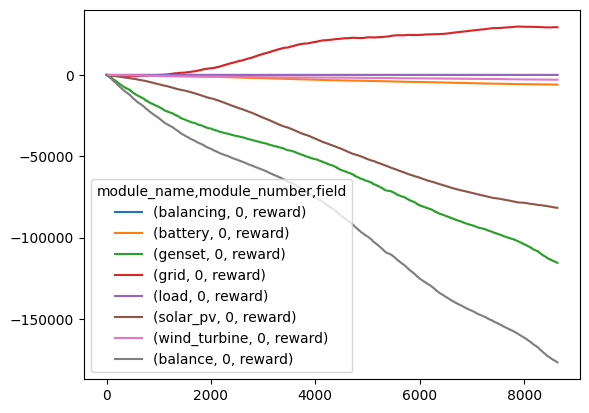

In [345]:
microgrid.log.loc[:, pd.IndexSlice[:, :, "reward"]].cumsum().plot()
plt.show()